In [22]:
from work.load.main import (
    plot_saliency_time,
)
import joblib

results = joblib.load('output/results.joblib')
csv_name = next(iter(results.keys()))           # just take the first trained file
artifacts_path = results[csv_name]["artifacts_path"]

print(csv_name)



sap500.csv


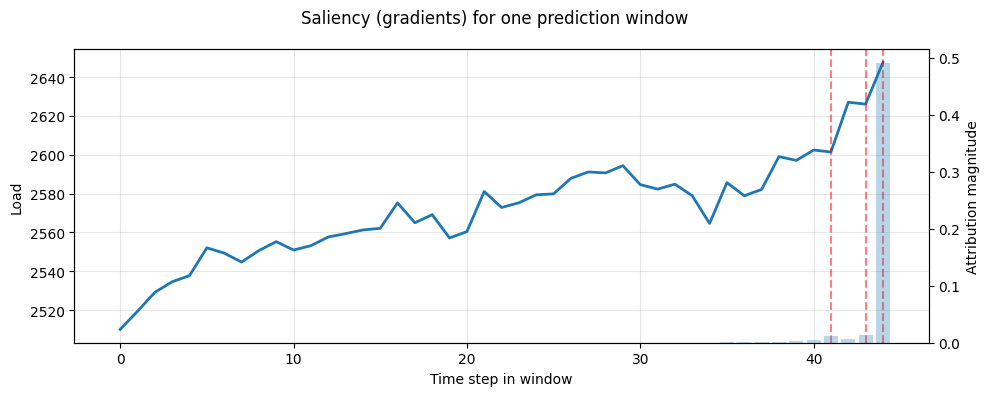

In [23]:
_ = plot_saliency_time(
    artifacts_path,
    example_index=453,
    method="saliency",   # or "ig"
    ig_steps=64,
    top_k=3,             # draw vertical lines on top-5 timesteps
)


In [24]:

from aix360.algorithms.tssaliency import TSSaliencyExplainer
import torch
import numpy as np

artifacts_path = results[csv_name]["artifacts_path"]
artifacts = joblib.load(artifacts_path)

model: torch.nn.Module = artifacts["model"]
scaler = artifacts["scaler"]
X_test: np.ndarray = artifacts["X_test"]       # shape (N, seq_len, 1)
config = artifacts["config"]
seq_len = int(config["seq_len"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# ------------------------------------------------------------------
# 2) Define the numpy-based model function for TSSaliency
# ------------------------------------------------------------------
def model_fn(x_np: np.ndarray) -> np.ndarray:
    """
    x_np: (T, F) or (B, T, F) with F == 1 (univariate load)
    returns: (B, 1) predictions in ORIGINAL units
    """
    x_arr = np.asarray(x_np, dtype=np.float32)

    if x_arr.ndim == 2:           # (T, F)
        x_arr = x_arr[None, ...]  # -> (1, T, F)
    elif x_arr.ndim != 3:
        raise ValueError(f"Unexpected input shape {x_arr.shape}")

    B, T, F = x_arr.shape
    if T != seq_len:
        raise ValueError(f"Expected seq_len={seq_len}, got T={T}")
    if F != 1:
        raise ValueError(f"Expected 1 feature (load), got F={F}")

    # scale like in training
    x_flat = x_arr.reshape(-1, 1)              # (B*T, 1)
    x_flat_scaled = scaler.transform(x_flat)   # (B*T, 1)
    x_scaled = x_flat_scaled.reshape(B, T, 1)  # (B, T, 1)

    x_tensor = torch.from_numpy(x_scaled).to(device)

    with torch.no_grad():
        y_scaled = model(x_tensor).cpu().numpy()  # (B,)

    # inverse-transform prediction
    y_scaled_2d = y_scaled.reshape(-1, 1)
    y_unscaled = scaler.inverse_transform(y_scaled_2d).ravel()  # (B,)

    return y_unscaled.reshape(B, 1)  # (B, 1)

# ------------------------------------------------------------------
# 3) Build TSSaliencyExplainer (this is the analogue of your snippet)
# ------------------------------------------------------------------
# base value = mean load over training set in original units
X_train = artifacts["X_train"]                 # (N_train, seq_len, 1) – scaled
train_flat_scaled = X_train.reshape(-1, 1)
train_flat_unscaled = scaler.inverse_transform(train_flat_scaled)
base_value = [float(train_flat_unscaled.mean())]

explainer = TSSaliencyExplainer(
    model=model_fn,
    input_length=seq_len,
    feature_names=["load"],
    base_value=base_value,
    n_samples=50,
    gradient_samples=100,
)



In [25]:
from aix360.algorithms.tsutils.tsframe import tsFrame
import pandas as pd

indx = 3
instance = X_test[indx, ...]
base_value = np.mean(instance, axis=0) # base value 

ts_instance = tsFrame(instance) # tsFrame instance
ts_instance.index = pd.to_numeric(ts_instance.index)
ts_instance



,X_1
time,
0,4.966094
1,5.047519
2,4.961921
3,4.862157
4,4.904983
5,4.953904
6,5.023415
7,5.014356
8,5.002029


In [26]:
explanation = explainer.explain_instance(ts_instance, base_value=base_value)

instance_prediction = explanation["instance_prediction"]
base_value_prediction = explanation["base_value_prediction"]

pred_delta = instance_prediction - base_value_prediction
saliency_sum = np.sum(explanation['saliency'])

print("Sum of Saliency scores (Integrated Gradient): {}".format(saliency_sum))
print("f(instance) - f(base): {}".format(pred_delta))
print("|f(instance) - f(base) - sum IG|: {}".format(np.abs(pred_delta - saliency_sum)))



Sum of Saliency scores (Integrated Gradient): -0.10977054454273748
f(instance) - f(base): [-0.09617615]
|f(instance) - f(base) - sum IG|: [0.0135944]


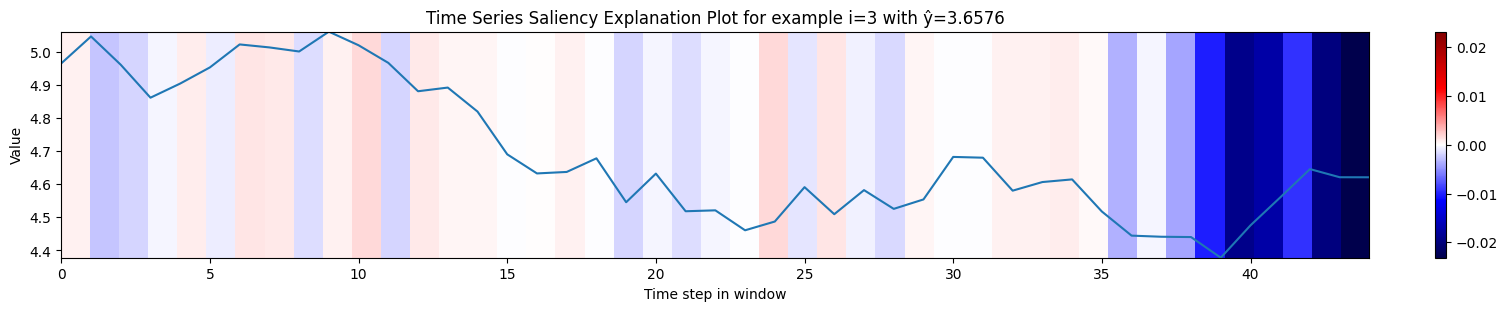

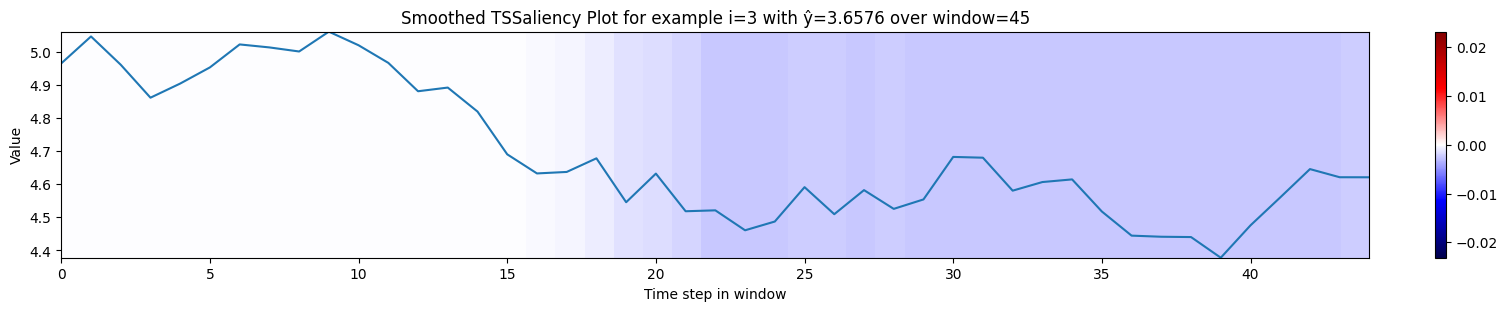

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_explanation(instance, scores, title, vmax):
    T = len(scores)
    x = np.arange(T)

    ymin = float(np.min(instance))
    ymax = float(np.max(instance))

    plt.figure(figsize=(15, 3), layout='constrained')

    # draw saliency as a band covering the same y-range as the series
    plt.imshow(
        scores[np.newaxis, :],
        aspect='auto',
        cmap='seismic',
        vmin=-vmax,
        vmax=vmax,
        extent=[0, T - 1, ymin, ymax],  # align with series y-range
        origin='lower',                  # flip so “up” is up
    )
    plt.colorbar()

    plt.plot(x, instance, color='tab:blue', linewidth=1.5)
    plt.xlim(0, T - 1)
    plt.ylim(ymin, ymax)

    plt.title(title)
    plt.xlabel("Time step in window")
    plt.ylabel("Value")
    plt.show()


# --- saliency and "prediction" for regression -------------------------

saliency = np.asarray(explanation['saliency']).flatten()
max_abs = np.max(np.abs(saliency))

# try to get prediction from explanation dict, if TSSaliency stored it
# if not there, this becomes None and we just skip it in the title.
pred_list = explanation.get("instance_prediction", None)
if pred_list is not None:
    y_pred = float(np.ravel(pred_list)[0])
    base_title = f"example i={indx} with ŷ={y_pred:.4f}"
else:
    base_title = f"example i={indx}"

# raw TSSaliency
plot_explanation(
    instance=instance,
    scores=saliency,
    title=f"Time Series Saliency Explanation Plot for {base_title}",
    vmax=max_abs,
)

# smoothed TSSaliency
window = 45
convolve_saliency = (
    np.convolve(saliency, np.ones(window), mode='same') / window
)

plot_explanation(
    instance=instance,
    scores=convolve_saliency,
    title=f"Smoothed TSSaliency Plot for {base_title} over window={window}",
    vmax=max_abs,
)


Using artifacts from: C:\Users\janav\Documents\projects\xai-sandbox\work\sp500\output\sap500_artifacts.joblib


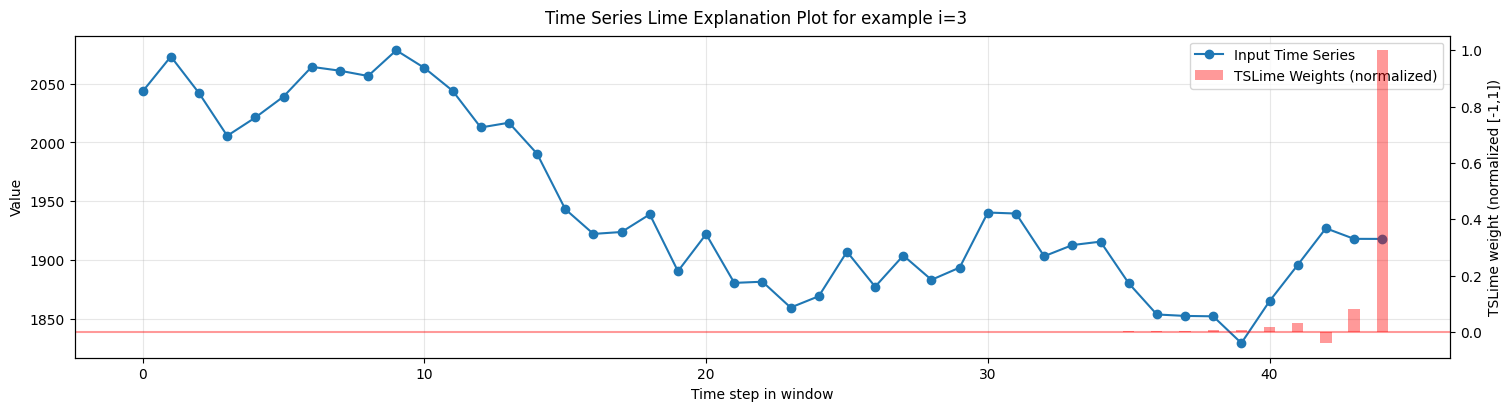

In [37]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import functools

from pathlib import Path
import joblib

from aix360.algorithms.tslime import TSLimeExplainer
from aix360.algorithms.tsutils.tsframe import tsFrame
from aix360.algorithms.tsutils.tsperturbers import BlockBootstrapPerturber

# -----------------------------------------------------------------------------
# 1) Load artifacts (use your existing results.joblib)
# -----------------------------------------------------------------------------
results = joblib.load("output/results.joblib")
csv_name = next(iter(results.keys()))
artifacts_path = Path(results[csv_name]["artifacts_path"])
print("Using artifacts from:", artifacts_path)

artifacts = joblib.load(artifacts_path)
model: torch.nn.Module = artifacts["model"]
scaler = artifacts["scaler"]
X_test: np.ndarray = artifacts["X_test"]  # shape (N, seq_len, 1)
config = artifacts["config"]
seq_len = int(config["seq_len"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# -----------------------------------------------------------------------------
# 2) Wrap the LSTM into a numpy -> numpy function for TSLime (regression)
# -----------------------------------------------------------------------------
def model_fn(x_np: np.ndarray) -> np.ndarray:
    """
    x_np: (T, F) or (B, T, F), with F == 1 (univariate load)
    returns: (B, 1) predictions in ORIGINAL units
    """
    x_arr = np.asarray(x_np, dtype=np.float32)

    if x_arr.ndim == 2:            # (T, F)
        x_arr = x_arr[None, ...]   # -> (1, T, F)
    elif x_arr.ndim != 3:
        raise ValueError(f"Unexpected input shape {x_arr.shape}")

    B, T, F = x_arr.shape
    if T != seq_len:
        raise ValueError(f"Expected seq_len={seq_len}, got T={T}")
    if F != 1:
        raise ValueError(f"Expected 1 feature, got F={F}")

    # scale like in training
    x_flat = x_arr.reshape(-1, 1)              # (B*T, 1)
    x_flat_scaled = scaler.transform(x_flat)   # (B*T, 1)
    x_scaled = x_flat_scaled.reshape(B, T, 1)  # (B, T, 1)

    x_tensor = torch.from_numpy(x_scaled).to(device)

    with torch.no_grad():
        y_scaled = model(x_tensor).cpu().numpy()  # (B,)

    # inverse-transform to original units
    y_scaled_2d = y_scaled.reshape(-1, 1)
    y_unscaled = scaler.inverse_transform(y_scaled_2d).ravel()  # (B,)

    return y_unscaled.reshape(B, 1)  # (B, 1)

input_length = seq_len
relevant_history = min(100, input_length)

perturber = BlockBootstrapPerturber(
    window_length=min(10, input_length - 1),
    block_length=min(20, input_length),
    block_swap=2,
)

explainer = TSLimeExplainer(
    model=model_fn,
    input_length=input_length,
    relevant_history=relevant_history,
    perturbers=[perturber],
    n_perturbations=1000,
    random_seed=22,
)

# -----------------------------------------------------------------------------
# 3) Build tsFrame for one example and run TSLime
# -----------------------------------------------------------------------------
indx = 3  # pick any valid test index
instance_scaled = X_test[indx, :, :]                        # (T, 1) scaled
instance = scaler.inverse_transform(instance_scaled)[:, 0]  # (T,) original units

# tsFrame from numpy (shape (T, 1)); dt=1 gives simple numeric index
ts_instance = tsFrame(instance.reshape(-1, 1))
ts_instance.index = pd.to_numeric(ts_instance.index)  # numeric index, like demo

explanation = explainer.explain_instance(ts_instance)

# -----------------------------------------------------------------------------
# 4) Plot TSLime explanation (regression version of their demo)
# -----------------------------------------------------------------------------


# last 'relevant_history' points
relevant_df = instance[-relevant_history:]
history_weights = np.asarray(explanation["history_weights"]).flatten()
history_weights = history_weights[-relevant_history:]

# normalize like the demo
normalized_weights = history_weights / np.mean(np.abs(history_weights))

history_weights = np.asarray(explanation["history_weights"]).flatten()
history_weights = history_weights[-relevant_history:]

# normalize to [-1, 1]
max_abs_w = np.max(np.abs(history_weights)) + 1e-12
weights_norm = history_weights / max_abs_w

relevant_series = instance[-relevant_history:]
T = len(relevant_series)
x = np.arange(T)

fig, ax1 = plt.subplots(figsize=(15, 4), layout="constrained")

# price on left axis
ax1.plot(x, relevant_series, marker="o", label="Input Time Series")
ax1.set_xlabel("Time step in window")
ax1.set_ylabel("Value")
ax1.grid(True, alpha=0.3)

# weights on right axis
ax2 = ax1.twinx()
ax2.bar(
    x,
    weights_norm,
    width=0.4,
    color="red",
    alpha=0.4,
    label="TSLime Weights (normalized)",
)
ax2.set_ylabel("TSLime weight (normalized [-1,1])")
ax2.axhline(0.0, color="r", linestyle="-", alpha=0.4)

fig.suptitle(f"Time Series Lime Explanation Plot for example i={indx}")

# combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.show()